In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

In [37]:
class MNISTDataset(Dataset):
    def __init__(self, csv_file):
        data = pd.read_csv(csv_file)
        self.labels = data['label'] if 'label' in data.columns else None
        self.images = data.drop('label', axis=1).values if self.labels is not None else data.values

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].astype(np.float32).reshape(1, 28, 28) / 255.0
        if self.labels is not None:
            label = self.labels[idx]
            return torch.from_numpy(image), label
        return torch.from_numpy(image), _

In [38]:
train_dataset = MNISTDataset('/content/data/train.csv')
train_data, val_data = train_test_split(train_dataset, test_size=0.2, random_state=42)
test_dataset = MNISTDataset('/content/data/test.csv')

In [39]:
batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [42]:
print(f"Number of training samples: {len(train_data)}")
print(f"Number of validation samples: {len(val_data)}")
print(f"Number of test samples: {len(test_dataset)}")

# Check the shape of a single batch
images, labels = next(iter(test_loader))
print(f"Batch shape: {images.shape}")
print(f"Labels shape: {labels}")

Number of training samples: 33600
Number of validation samples: 8400
Number of test samples: 28000
Batch shape: torch.Size([64, 1, 28, 28])
Labels shape: ('', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '', '')


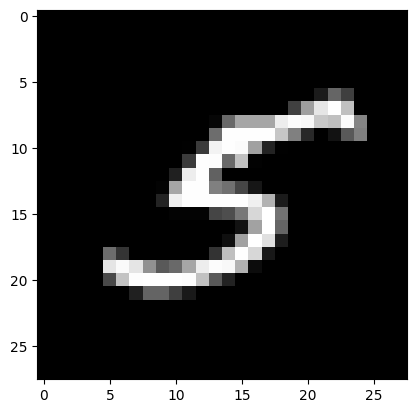

Label: 5


In [6]:
import matplotlib.pyplot as plt

# Function to show an image
def show_image(img):
    img = img.numpy().squeeze()
    plt.imshow(img, cmap='gray')
    plt.show()

# Display the first image from the batch
show_image(images[0])
print(f'Label: {labels[0].item()}')

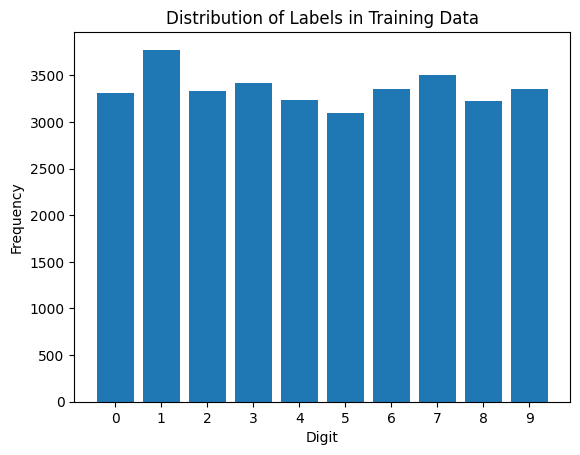

In [7]:
import numpy as np

# Collect all labels
all_labels = [label for _, label in train_loader]
all_labels = torch.cat(all_labels).numpy()

# Plot the histogram
plt.hist(all_labels, bins=np.arange(11)-0.5, rwidth=0.8)
plt.title('Distribution of Labels in Training Data')
plt.xlabel('Digit')
plt.ylabel('Frequency')
plt.xticks(range(10))
plt.show()

In [8]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

In [31]:
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        # Convolutional layers
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # Dropout
        self.dropout = nn.Dropout(0.25)
        # Fully connected layers (unchanged)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Convolutional and pooling layers
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = self.pool(x)  # Second pooling layer
        x = self.dropout(x)
        # Flatten
        x = x.view(x.size(0), -1)
        # Fully connected layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [32]:
model = CNNModel()

# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [33]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [34]:
import time
import matplotlib.pyplot as plt
import torch

def train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device):
    start_time = time.time()
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0

        for batch_idx, (images, labels) in enumerate(train_loader):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = 100 * correct_train / total_train
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # Validation phase
        model.eval()
        val_loss = 0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for data, target in val_loader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                val_loss += criterion(output, target).item() * data.size(0)
                _, predicted = torch.max(output.data, 1)
                total_val += target.size(0)
                correct_val += (predicted == target).sum().item()

        val_loss /= len(val_loader.dataset)
        val_acc = 100 * correct_val / total_val
        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        # Print epoch summary
        print(f'Epoch [{epoch+1}/{num_epochs}]')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.2f}%')
        print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

    end_time = time.time()
    training_time = end_time - start_time
    print(f'Training completed in {training_time:.2f} seconds')

    # Plot training and validation metrics
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
    plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch [1/20], Step [100/525], Loss: 0.2625
Epoch [1/20], Step [200/525], Loss: 0.1668
Epoch [1/20], Step [300/525], Loss: 0.0751
Epoch [1/20], Step [400/525], Loss: 0.1495
Epoch [1/20], Step [500/525], Loss: 0.0884
Epoch [1/20]
Train Loss: 0.2916, Train Acc: 91.12%
Val Loss: 0.0842, Val Acc: 97.46%
--------------------------------------------------
Epoch [2/20], Step [100/525], Loss: 0.1166
Epoch [2/20], Step [200/525], Loss: 0.0661
Epoch [2/20], Step [300/525], Loss: 0.0533
Epoch [2/20], Step [400/525], Loss: 0.0297
Epoch [2/20], Step [500/525], Loss: 0.1325
Epoch [2/20]
Train Loss: 0.0882, Train Acc: 97.39%
Val Loss: 0.0506, Val Acc: 98.37%
--------------------------------------------------
Epoch [3/20], Step [100/525], Loss: 0.1121
Epoch [3/20], Step [200/525], Loss: 0.0217
Epoch [3/20], Step [300/525], Loss: 0.0397
Epoch [3/20], Step [400/525], Loss: 0.0398
Epoch [3/20], Step [500/525], Loss: 0.0277
Epoch [3/20]
Train Loss: 0.0682, Train Acc: 97.83%
Val Loss: 0.0515, Val Acc: 98.39

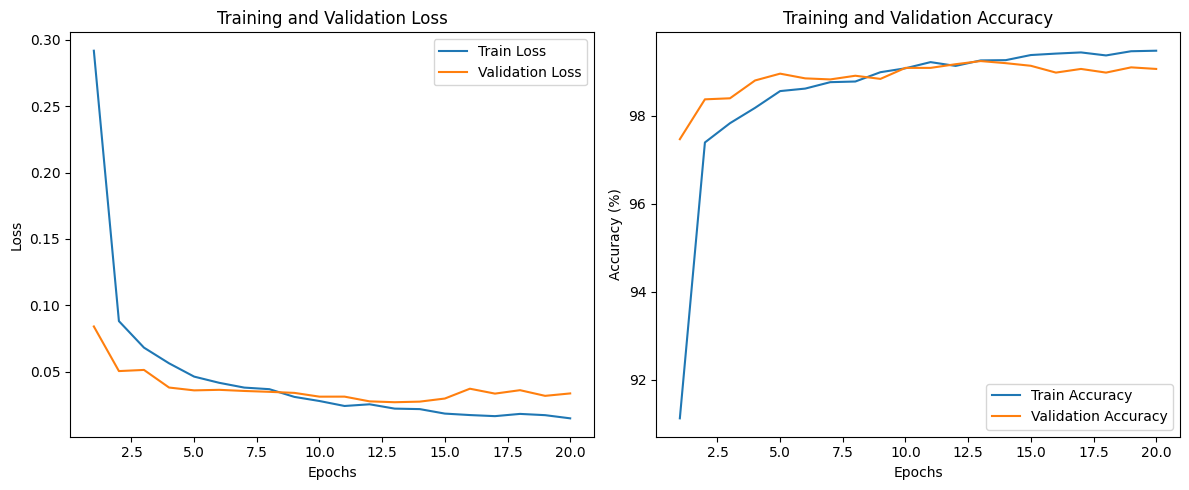

In [35]:
num_epochs = 20
train_and_validate(model, train_loader, val_loader, criterion, optimizer, num_epochs, device)

In [36]:
torch.save(model, 'digit_recogonizer.pth')

In [43]:
import torch
import csv
from tqdm import tqdm  # For progress visualization

def generate_submission(model, device, test_loader, output_file='submission.csv'):
    """
    Generates a submission CSV file with ImageId and predicted Label for each test image.

    Parameters:
    - model: Trained PyTorch model.
    - device: Device to perform computations on ('cpu' or 'cuda').
    - test_loader: DataLoader for the test dataset.
    - output_file: Filename for the submission CSV.
    """
    model.eval()  # Set model to evaluation mode
    predictions = []  # List to store predictions

    # Disable gradient computation for efficiency
    with torch.no_grad():
        # Iterate over test_loader with a progress bar
        for batch_idx, (images, _) in enumerate(tqdm(test_loader, desc="Generating Predictions")):
            # Move images to the specified device
            images = images.to(device)

            # Forward pass: Get model outputs
            outputs = model(images)

            # Get predicted labels by taking the index of the max log-probability
            preds = outputs.argmax(dim=1).cpu().numpy()

            # Calculate ImageId for the current batch
            # Assuming ImageIds start at 1 and increment by 1 for each image
            start_id = batch_idx * test_loader.batch_size + 1
            for i, pred in enumerate(preds):
                image_id = start_id + i
                predictions.append([image_id, int(pred)])

    # Write predictions to CSV
    with open(output_file, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['ImageId', 'Label'])  # Write header
        writer.writerows(predictions)  # Write data rows

    print(f'Submission file "{output_file}" has been generated with {len(predictions)} entries.')

In [44]:
generate_submission(model, device, test_loader, output_file='submission.csv')

Generating Predictions: 100%|██████████| 438/438 [00:02<00:00, 157.23it/s]


Submission file "submission.csv" has been generated with 28000 entries.
